## Classification

In [65]:
from IPython import get_ipython
if get_ipython():
    get_ipython().run_line_magic('load_ext', 'autoreload')
    get_ipython().run_line_magic('autoreload', '2')

import numpy as np
import pandas as pd
import torch

import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

import latenta as la
la.logger.setLevel("INFO")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generative model

In [66]:
n_samples = 100
sample_ids = [str(i) for i in range(n_samples)]
sample_index = pd.Series(sample_ids, name = "cell")

x = la.Fixed(pd.Series(np.random.uniform(0, 3, n_samples), index = sample_index), label = "x")

In [67]:
n_clusters = 4
cluster_ids = [str(i) for i in range(n_clusters)]
cluster_index = pd.Series(cluster_ids, name = "feature")

beta = la.Fixed(pd.Series([-2, -2, 2, 2], index = cluster_index), label = "beta")

bias = la.Fixed(pd.Series([1, 1, -1, -1], index = cluster_index), label = "bias")

In [68]:
concentration = la.links.scalar.Linear(x, beta, b = bias, transforms = [la.transforms.Exp()])

In [69]:
probs = la.distributions.Dirichlet(concentration)

In [70]:
dist = la.distributions.OneHotCategorical(probs)


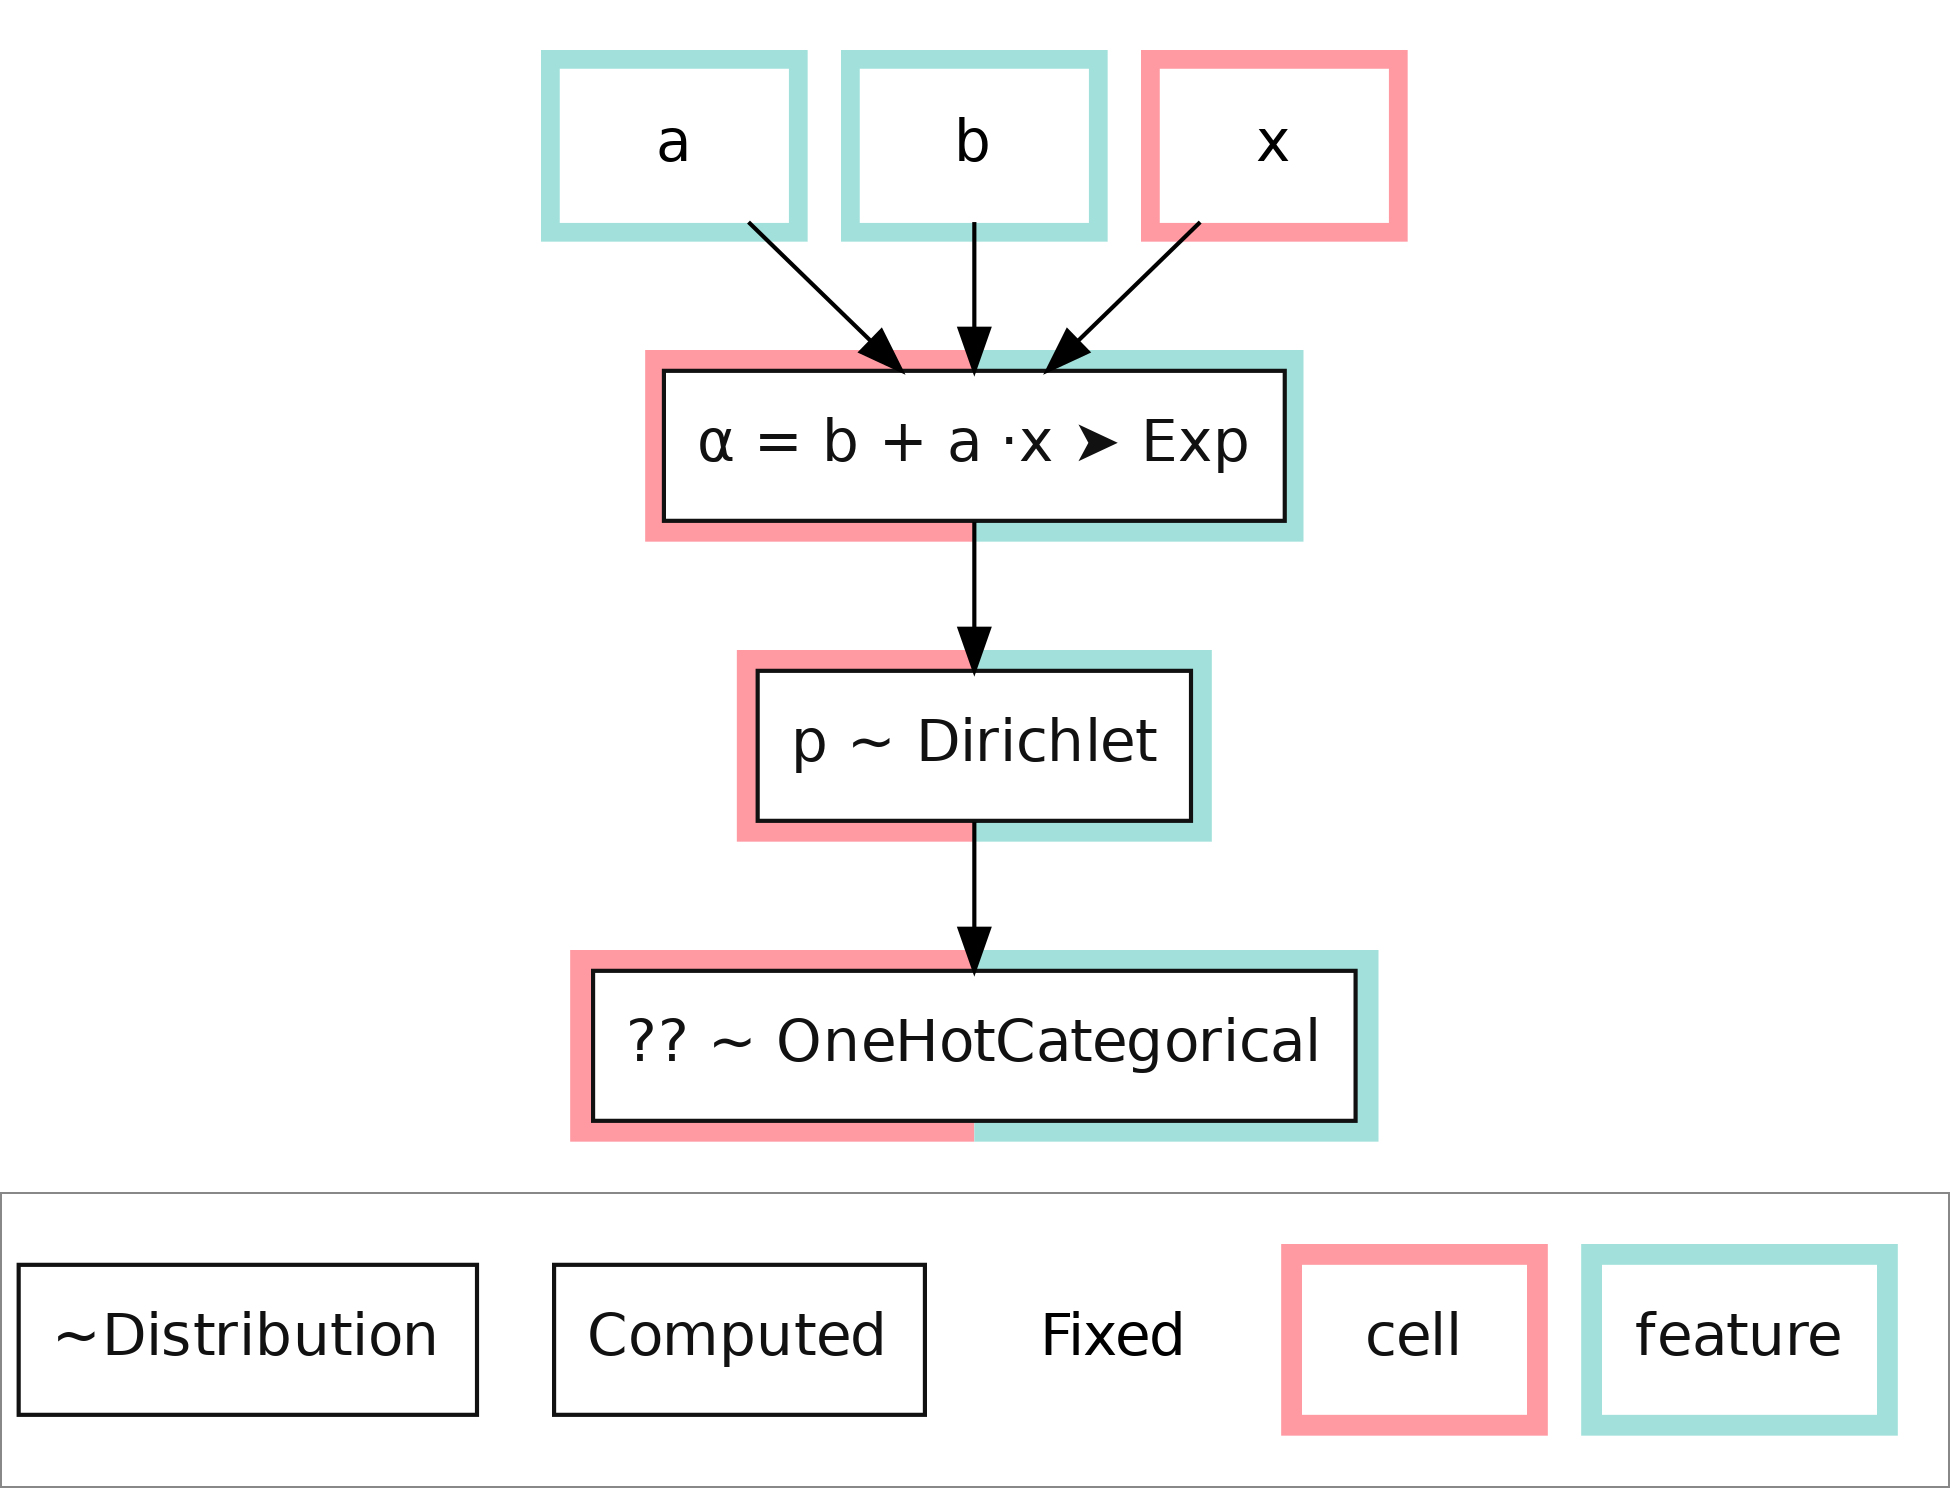

In [71]:
dist.plot()

In [72]:
posterior = la.posterior.Posterior(dist)
posterior.sample(10)

  0%|          | 0/10 [00:00<?, ?it/s]

<AxesSubplot:xlabel='feature', ylabel='cell'>

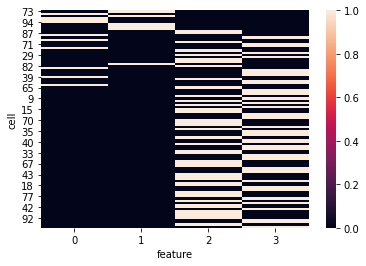

In [73]:
observation_value = posterior.samples[dist].sel(sample = 0).to_pandas()
sns.heatmap(observation_value.iloc[np.argsort(x.prior_pd())])

## Classification based on observed x

In [74]:
cluster_definition = la.Definition.from_xr(observation_value)

In [75]:
concentration = la.links.scalar.Linear(x, b = True, a = True, output = cluster_definition, transforms = [la.transforms.Exp()])

In [76]:
probs = la.distributions.Dirichlet(concentration)
onehot = la.distributions.OneHotCategorical(probs)
observation = la.Observation(observation_value, onehot, label = "observation")


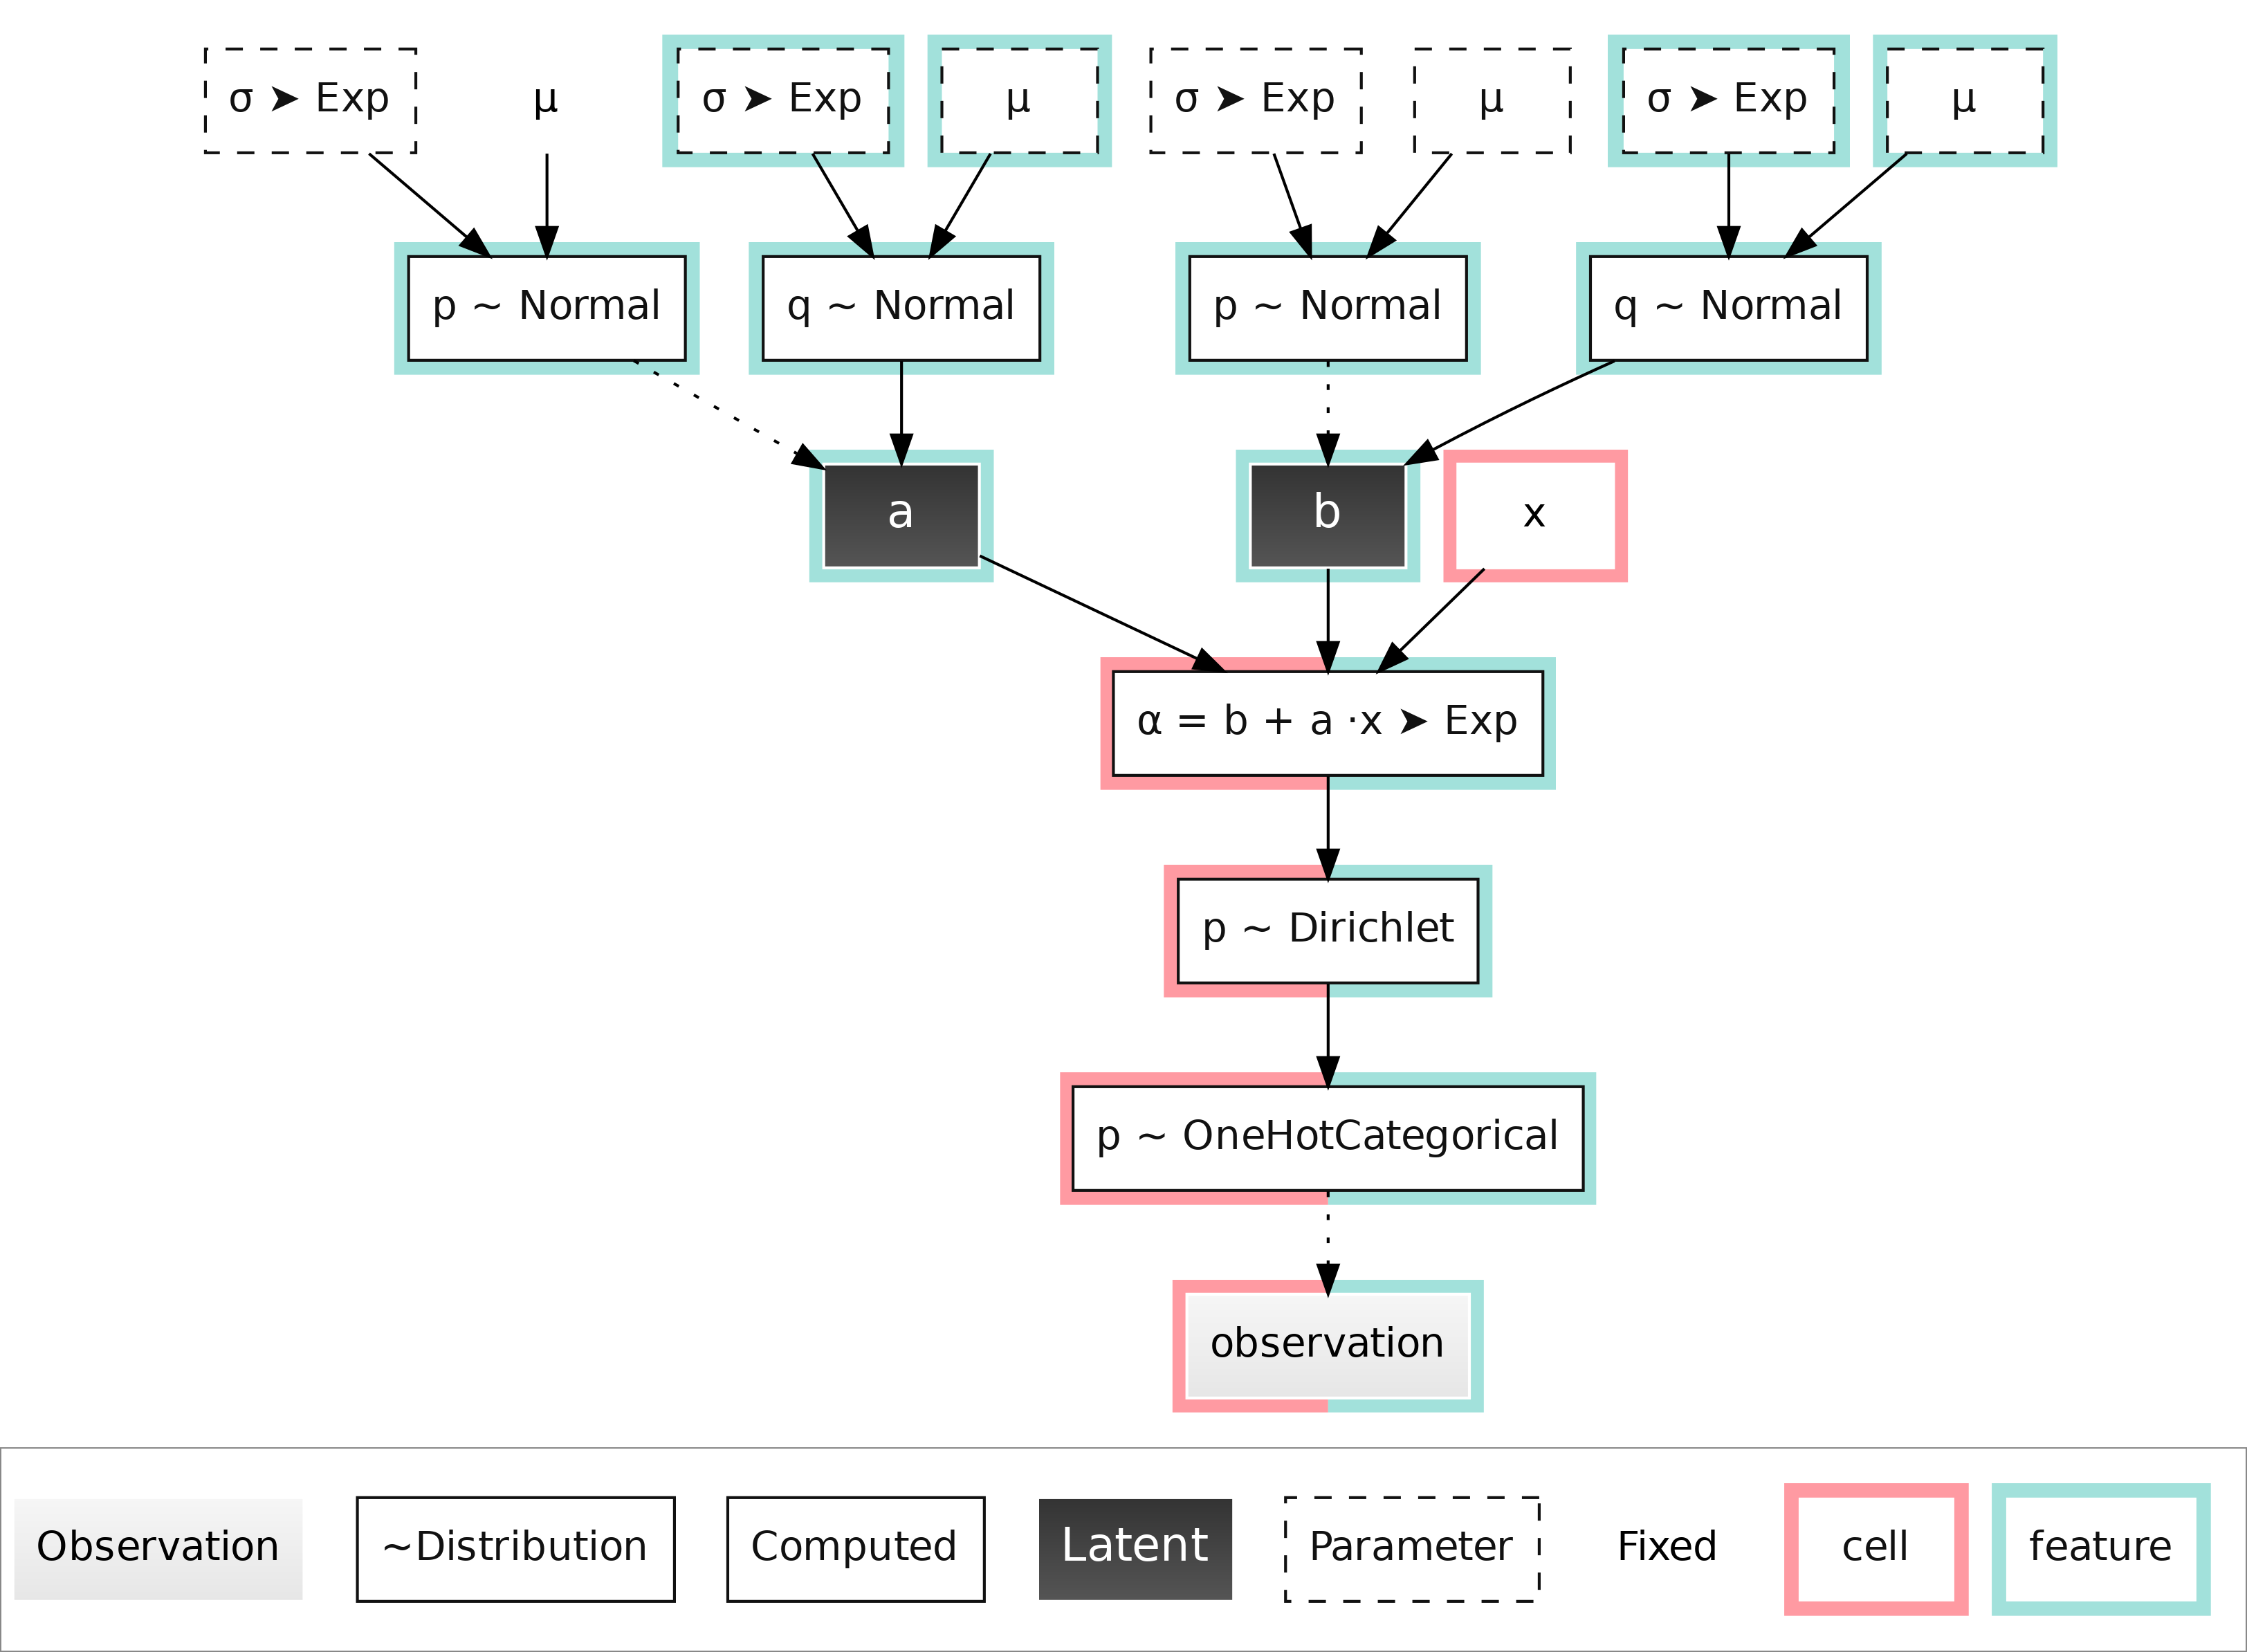

In [77]:
observation.plot()

In [78]:
model = la.Model(observation)

In [82]:
inference = la.infer.svi.SVI(model, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr = 0.05))
trainer = la.infer.trainer.Trainer(inference)
trace = trainer.train(10000)

  0%|                                                                                                         …

In [83]:
posterior = la.posterior.Posterior(observation)
posterior.sample(10)

  0%|          | 0/10 [00:00<?, ?it/s]

<AxesSubplot:xlabel='feature', ylabel='cell'>

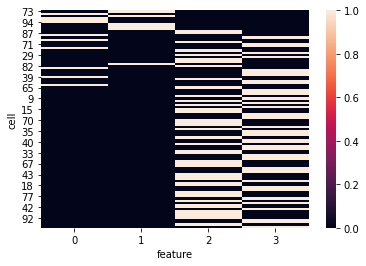

In [84]:
sns.heatmap(observation_value.iloc[np.argsort(x.prior().numpy())])

<AxesSubplot:xlabel='feature', ylabel='cell'>

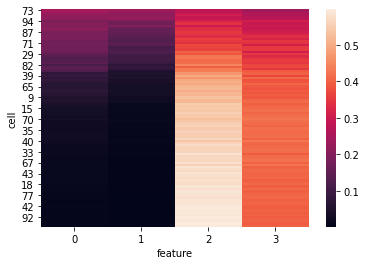

In [85]:
modelled_value = posterior.samples[probs].mean("sample").to_pandas()
sns.heatmap(modelled_value.iloc[np.argsort(x.prior().numpy())])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

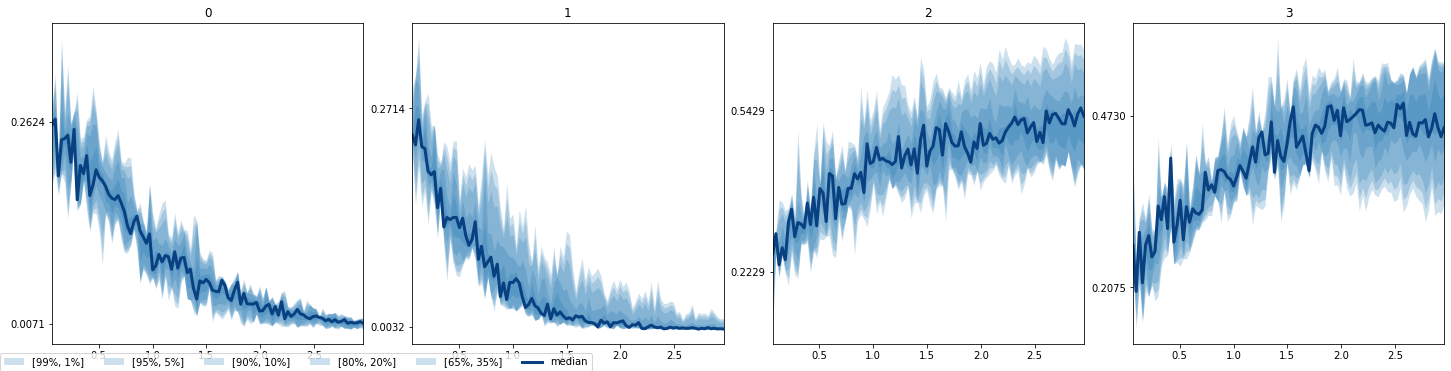

In [91]:
causal = la.posterior.scalar.ScalarVectorCausal(x, observation)
causal.observed.sample(1)
causal.sample(5)
causal.plot_features(observation.p.probs);

## Classification based on observed x (2)

An example with softmax transform

In [92]:
probs = la.links.scalar.Linear(x, b = True, a = True, output = cluster_definition, transforms = [la.transforms.Softmax()])

In [93]:
onehot = la.distributions.OneHotCategorical(probs)
observation = la.Observation(observation_value, onehot, label = "observation")


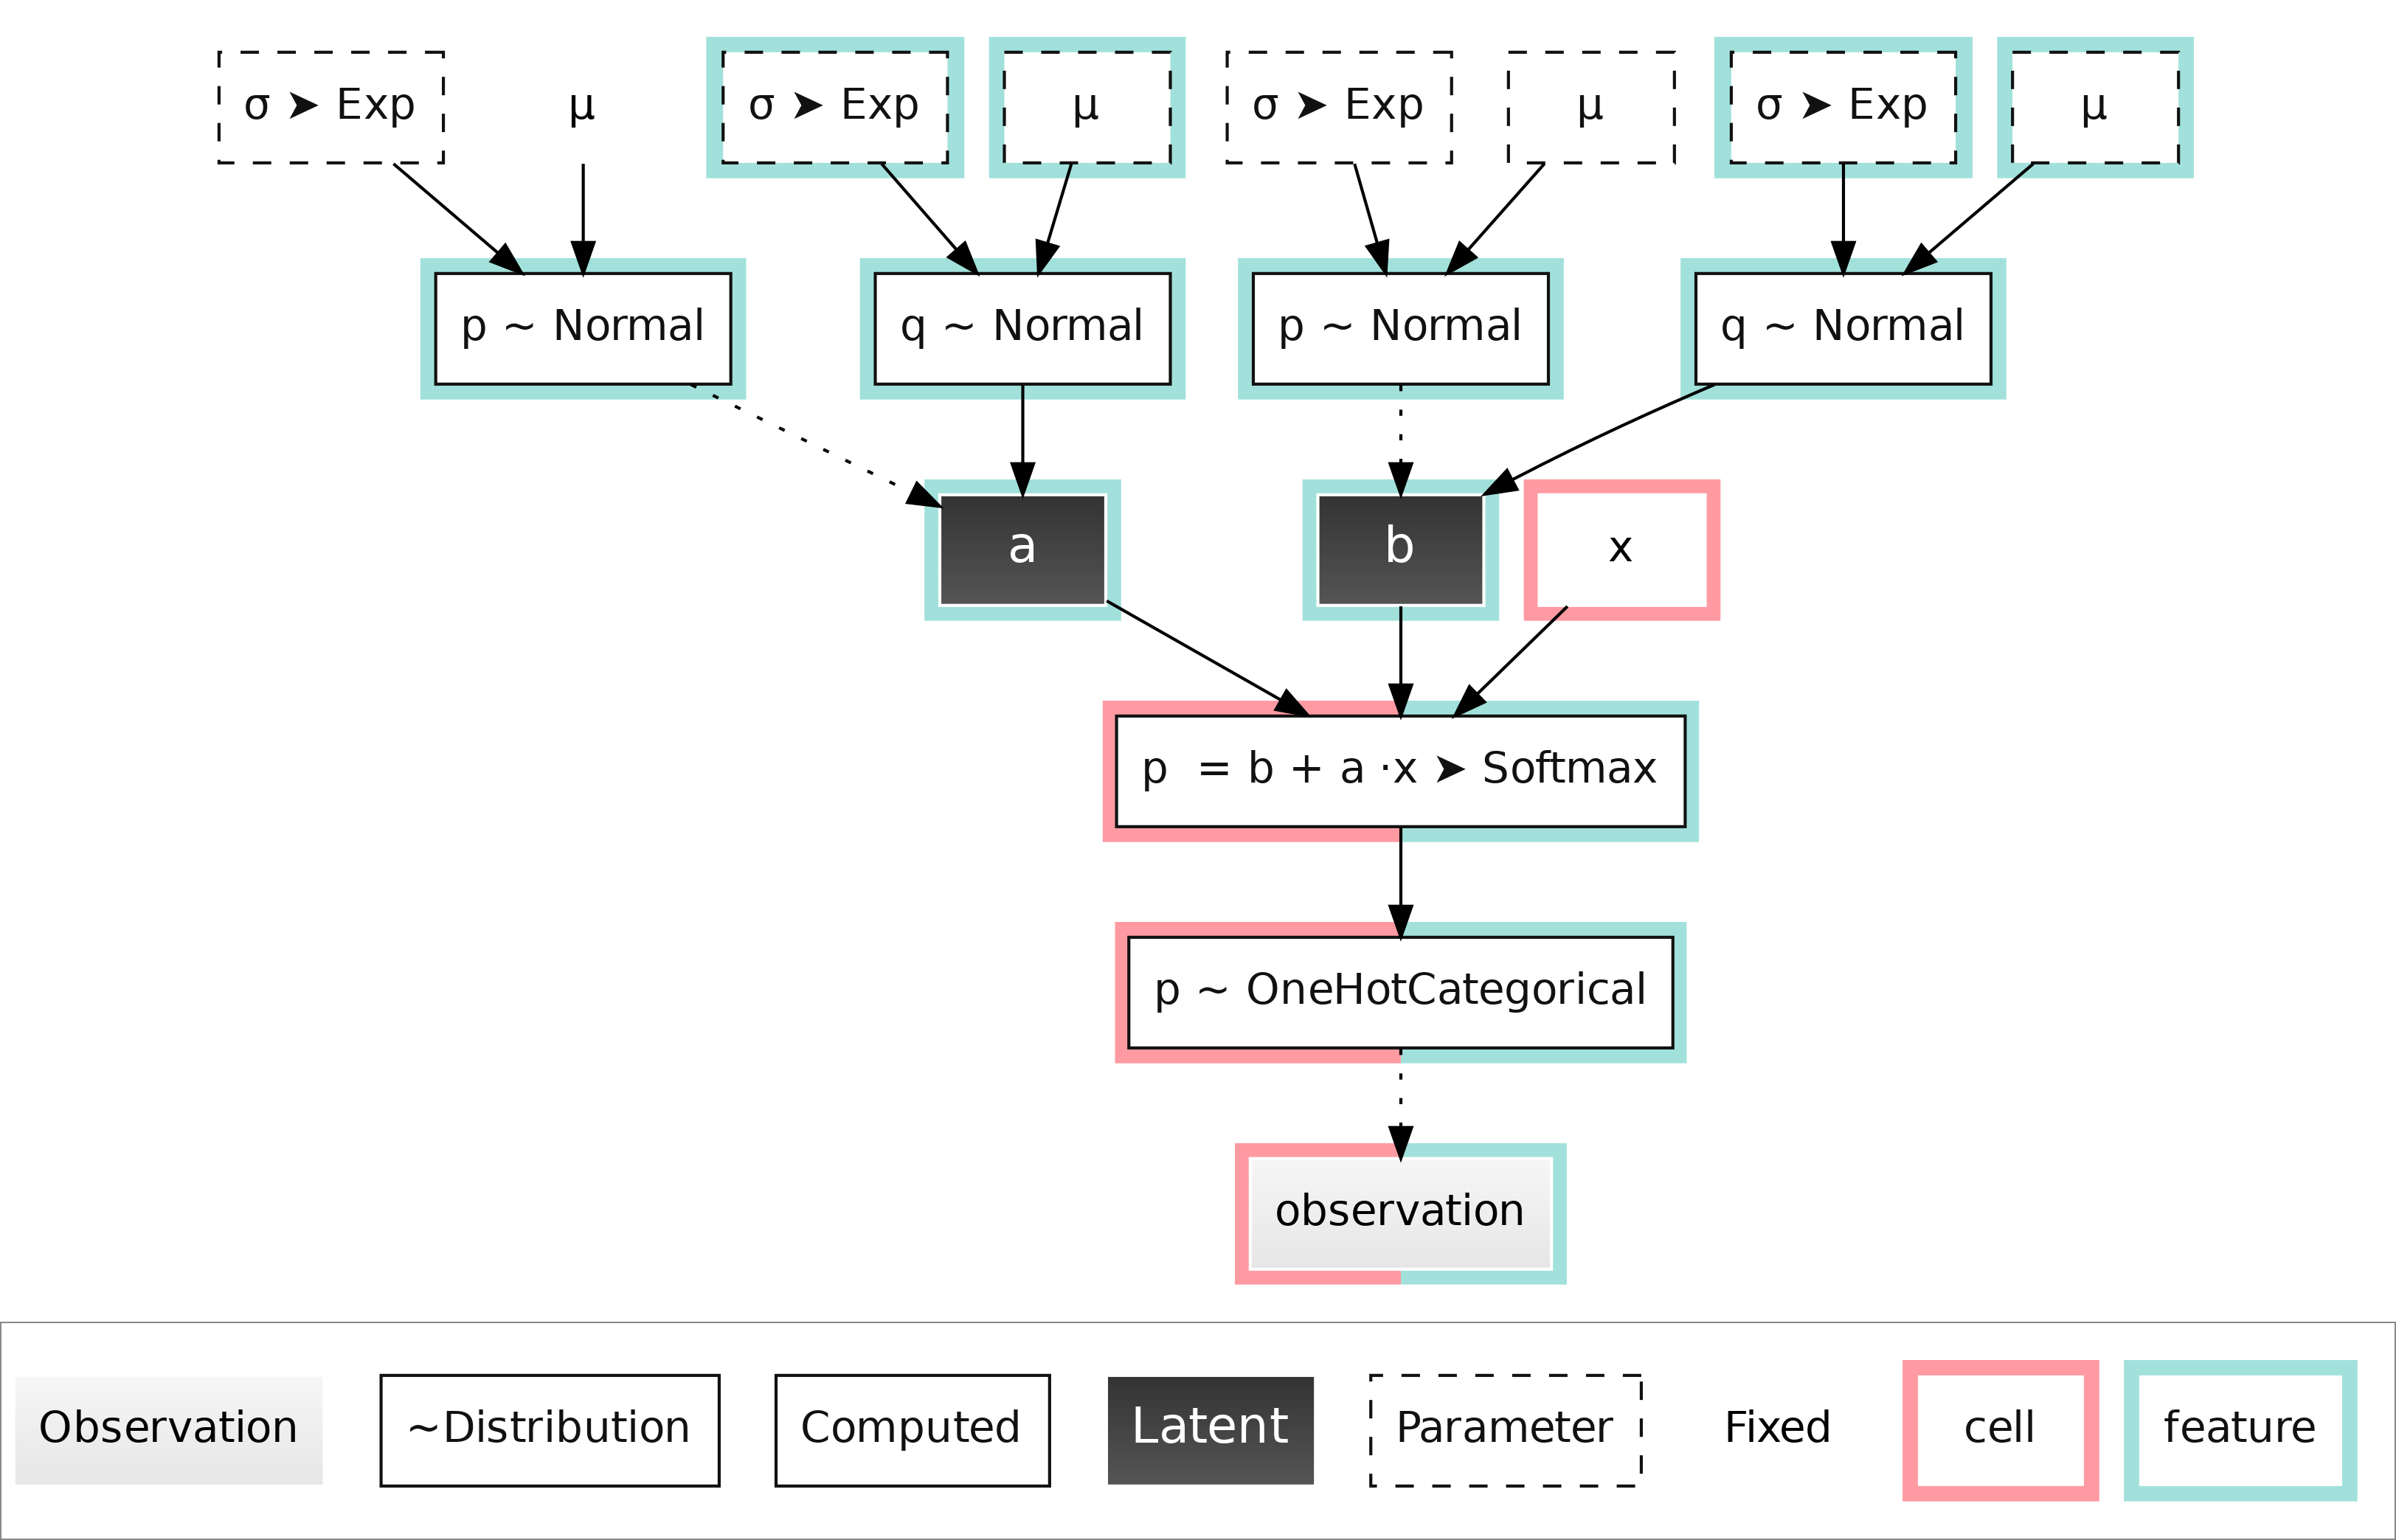

In [94]:
observation.plot()

In [95]:
model = la.Model(observation)

In [97]:
inference = la.infer.svi.SVI(model, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr = 0.05))
trainer = la.infer.trainer.Trainer(inference)

In [98]:
trace = trainer.train(10000)

  0%|                                                                                                         …

In [99]:
posterior = la.posterior.Posterior(observation)
posterior.sample(10)

  0%|          | 0/10 [00:00<?, ?it/s]

<AxesSubplot:xlabel='feature', ylabel='cell'>

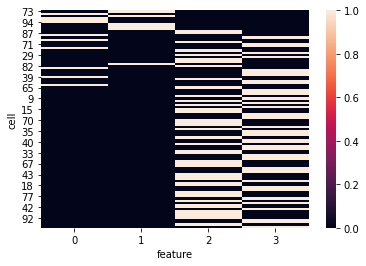

In [100]:
sns.heatmap(observation_value.iloc[np.argsort(x.prior().numpy())])

<AxesSubplot:xlabel='feature', ylabel='cell'>

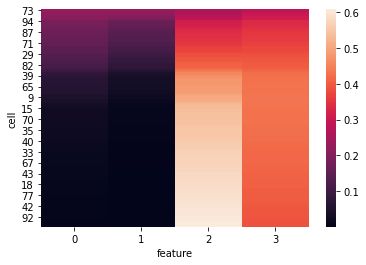

In [101]:
modelled_value = posterior.samples[probs].mean("sample").to_pandas()
sns.heatmap(modelled_value.iloc[np.argsort(x.prior().numpy())])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

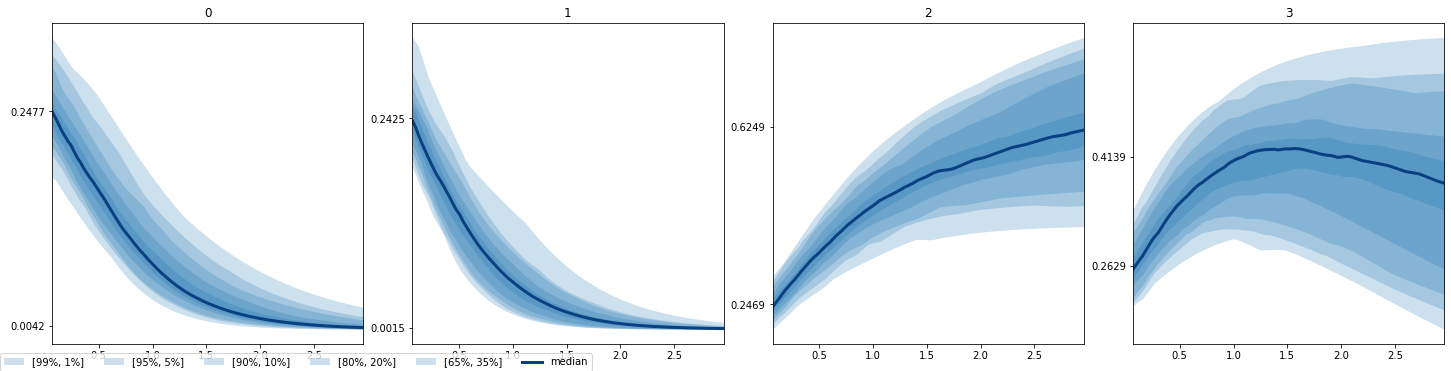

In [102]:
causal = la.posterior.scalar.ScalarVectorCausal(x, observation)
causal.observed.sample(1)
causal.sample(100)
causal.plot_features();

## Classification using latent x

This doesn't really work, given that we try to predict a single discrete variable using a continuous variable. See the combined regression + classification example for where this can work